In [1]:
#indir = "/data/Mito_Trace/output/annotation_clones/data/cd34norm/MTblacklist/DE_large"
indir = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/vireo/nclones20/annotation_clones/DE_large/minPct_0__logThresh_0"

se_indir = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/vireo/nclones20/annotation_clones/DE_large"
n_donors = 2
cdf_thresh = 0.3

n_top_genes = 5
n_top_clones = 3
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"


fdr.thresh=0.1

In [2]:
source(utils_script)

Attaching SeuratObject



In [3]:
outdir <- paste0(indir, "/", "cdf_thresh__", (cdf_thresh))
#dir.create(outdir)

In [4]:
library(Seurat)
library(Signac)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(magrittr)
library(cowplot)
library(metap)
library(dplyr)
library(future)
library("ComplexHeatmap")
library(motifmatchr)
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




Loading required package: B

## Import seurat object

In [5]:
se <- readRDS(file.path(se_indir, "se.clonesfilt.rds"))
init.large.clones <- read.csv(file.path(se_indir, "large_clones.csv"))
#large.clones <- init.large.clones %>% filter(cdf.norm<cdf_thresh)
#large.clones <- check.if.one.clone(large.clones, init.large.clones, n_top_clones)


large.clones = dplyr::bind_rows(lapply(0:(n_donors-1), 
                                       FUN=get.top.clones, clones=init.large.clones, 
                                       cdf_thresh=cdf_thresh, n_top_clones=n_top_clones))
large.clones

[1] "cdf thresh clones"
[1] 0 9


Warning message in if (dim(cdf.clones[1]) > n_top_clones) {:
“the condition has length > 1 and only the first element will be used”


[1] "cdf thresh clones"
[1] 0 9


Warning message in if (dim(cdf.clones[1]) > n_top_clones) {:
“the condition has length > 1 and only the first element will be used”


X,donor,lineage,norm.total,total,name,cdf.norm,cdf,index
<int>,<int>,<int>,<dbl>,<int>,<chr>,<dbl>,<int>,<int>
1,0,15,0.7193726,1632,0_15,0.3596863,1632,1
2,0,18,0.6783341,1430,0_18,0.6988534,3062,2
3,0,12,0.3371429,861,0_12,0.8674248,3923,3
4,1,1,0.9375503,2457,1_1,0.4687751,2457,1
5,1,5,0.4122695,1279,1_5,0.6749099,3736,2
6,1,2,0.4024528,1319,1_2,0.8761363,5055,3


In [6]:
se <- subset(se, subset= name %in% factor(large.clones$name))

In [7]:
Idents(se) <- "name"

## TF DE

## Summarize results

In [8]:
motifs.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                          row.names=row.names(se))
#colnames(motifs.pvals) <- large.clones$name
#motifs.pvals[,] = 1

all.names.sig <- c()
#motif.pvals = data.frame()
DefaultAssay(se) <- "chromvarnames"
for (d in 0:(n_donors-1)){
    print('donor')
    print(d)
    curr.indir <- file.path(indir, paste0("donor", d, "_TF"))

    donor.large.clones <- large.clones %>% filter(donor==d)
    if (dim(donor.large.clones)[1] < 2){
        print('no donor')
        next
    }
    clones.filt.ids <- sort(donor.large.clones$lineage)
    se.filt <- subset(se, subset = (donor==d) & (lineage %in% donor.large.clones$lineage))
    if (length(clones.filt.ids) < 2){
        print("0 or 1 clone found. not running")
        next
    }
    pairs = combn(clones.filt.ids,2)
    names.sig <- c()

    for (i in 1:dim(pairs)[2]){
        try({
        print(pairs[,i])
        print(paste("comparison #", i))
        a = pairs[1,i]
        b = pairs[2,i]
        curr.tf.da <- read.csv(file.path(curr.indir, 
                                         paste0("clones_",a,"__", b,".DE.TF.csv"))) %>% 
                      arrange(p_val)
        print(head(curr.tf.da))
        row.names(curr.tf.da) <- curr.tf.da$X  #sapply(curr.tf.da$X, function(m) {motifs@motif.names[[m]]})
        #curr.tf.da
        
        curr.sig <- curr.tf.da %>% filter(p_val_adj_BH<0.1)
        motifs.pvals[row.names(curr.sig),paste("d", d,"_a",a,"_b", b)] <-  curr.sig$p_val_adj_BH
        #motif.pvals = c(motif.pvals, curr.sig$p_val_adj_BH)
        curr.names <- row.names(curr.sig)
        names.sig <- c(names.sig, curr.names)# head(row.names(curr.tf.da), n_top_genes))
        all.names.sig <- c(all.names.sig, curr.names) #head(row.names(curr.tf.da), n_top_genes))
        DefaultAssay(se.filt) <- "ATAC"
        raw.ids <- names(Motifs(se.filt)@motif.names)
        rownames(curr.tf.da) <- sapply((curr.tf.da$X), function(x){raw.ids[match(x, Motifs(se.filt)@motif.names)]})
        })
    }
    DefaultAssay(se.filt) <- "chromvarnames"
    }
all.names.sig <- unique(all.names.sig)

[1] "donor"
[1] 0
[1] 12 15
[1] "comparison # 1"
            X        p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
1  FOSB::JUNB 1.770186e-10 0.4006399 0.614 0.511 1.120528e-07 5.596287e-08
2        JUND 1.836999e-10 0.3797221 0.628 0.511 1.162820e-07 5.596287e-08
3         FOS 3.967470e-10 0.3784288 0.619 0.517 2.511408e-07 5.596287e-08
4 FOSL2::JUNB 4.290588e-10 0.3932147 0.623 0.506 2.715942e-07 5.596287e-08
5    FOS::JUN 5.548351e-10 0.4025451 0.621 0.512 3.512106e-07 5.596287e-08
6       BATF3 5.639886e-10 0.3517140 0.636 0.518 3.570048e-07 5.596287e-08
[1] 12 18
[1] "comparison # 2"
      X        p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
1  CTCF 2.464507e-13 -0.3505065 0.405 0.522 1.560033e-10 1.560033e-10
2  ETV1 3.971252e-11  0.2703309 0.540 0.424 2.513802e-08 1.256901e-08
3   EHF 6.264440e-10  0.2305364 0.534 0.415 3.965390e-07 1.321797e-07
4 GABPA 2.303344e-09  0.2397023 0.542 0.431 1.458017e-06 3.645042e-07
5   YY2 2.500098e-08 -0.2493843 0.376 0.494 1

In [9]:
#motifs.pvals[is.na(motifs.pvals)] <- 1
motifs.pvals

#motifs.pvals <- -log10(motifs.pvals)

,d 0 _a 12 _b 15,d 0 _a 12 _b 18,d 0 _a 15 _b 18,d 1 _a 1 _b 2,d 1 _a 1 _b 5,d 1 _a 2 _b 5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FOXF2,1.729475e-02,NA,5.155284e-02,1.160505e-02,NA,NA
FOXD1,1.896060e-06,2.667857e-02,2.921217e-02,NA,NA,NA
IRF2,NA,NA,3.860805e-02,3.138002e-09,4.317457e-06,NA
MZF1(var.2),NA,NA,NA,NA,NA,NA
MAX::MYC,NA,NA,NA,NA,NA,NA
PPARG,NA,NA,NA,5.764455e-02,NA,NA
PAX6,NA,NA,NA,NA,NA,NA
PBX1,2.706113e-03,NA,2.784003e-02,NA,NA,NA
RORA,3.922880e-03,NA,9.351622e-02,NA,2.244211e-02,NA


In [10]:
sig.motifs.ordered <- sort(rowMeans(-log10(motifs.pvals),na.rm=T), decreasing=T)
sig.motifs.ordered

IRF4                IRF9               NFKB1                ETS2 
           9.202241            8.742983            7.515062            7.257906 
   JUN::JUNB(var.2)                IRF5         JDP2(var.2)         JUNB(var.2) 
           7.010475            6.933650            6.758903            6.657851 
               IRF8               CREB1               NFKB2                IRF3 
           6.648229            6.448916            6.434391            6.242323 
               CTCF  FOSL2::JUND(var.2)                ATF3                ETS1 
           6.157198            6.109672            5.915449            5.910297 
               ATF7                KLF3               BATF3              NFATC3 
           5.731016            5.690832            5.663514            5.603520 
               BATF               KLF15  FOSL2::JUNB(var.2)           FOSB::JUN 
           5.573884            5.542266            5.524267            5.499402 
              SNAI2                 FOS                ATF2           BATF::JUN 
           5.452587            5.435353            5.419222            5.412514 
      SREBF1(var.2)                RELA               CTCFL                NRF1 
           5.254674            5.221408            5.170990            5.112938 
               IRF2                 SP9               PRDM1                NFE2 
           5.093814            4.995772            4.951812            4.949196 
        FOSL2::JUNB                JUND                JUNB              SREBF1 
           4.873183            4.863399            4.861331            4.836817 
                SP4         FOSL2::JUND          JUN(var.2)                JDP2 
           4.832115            4.831523            4.732405            4.710286 
          FOS::JUNB                ZEB1   FOSL1::JUN(var.2)                 ERF 
           4.600500            4.593807            4.572783            4.555279 
              TCFL5                CREM         FOSL1::JUNB          FOSL2::JUN 
           4.523295            4.521328            4.425503            4.420806 
         FOSB::JUNB               SNAI3               FOSL1          FOSL1::JUN 
           4.414244            4.391656            4.360877            4.309399 
  FOSL2::JUN(var.2)            FOS::JUN                IRF7         JUND(var.2) 
           4.288265            4.266171            4.114573            4.074740 
                ERG                 JUN              ZBTB14                 REL 
           4.054054            4.042299            4.028262            3.985720 
               DUX4        STAT1::STAT2              ZNF460                FLI1 
           3.984375            3.969940            3.956110            3.842232 
               ETV1              NFATC2         FOSL1::JUND                 EHF 
           3.833047            3.772960            3.758335            3.755849 
              FOSL2     FOS::JUN(var.2)              NFE2L1              ZNF384 
           3.731989            3.705743            3.705135            3.688783 
               ETV2           FOS::JUND           JUN::JUNB              NFATC4 
           3.679260            3.663990            3.628728            3.627888 
              STAT1                ETV5                SIX2               FOXG1 
           3.608393            3.592665            3.564862            3.536361 
            BHLHE40                 FEV               BACH2                 SRY 
           3.511214            3.494156            3.483356            3.457420 
               DUXA              ZBTB33                MYF5                IRF6 
           3.446328            3.429053            3.420003            3.395984 
               KLF2   FOSB::JUNB(var.2)                PAX3              ZNF652 
           3.395727            3.387488            3.372667            3.343543 
               NFIB                 SP1           MAF::NFE2         NFIX(var.2) 
           3.330989            3.315526       

## Dotplot for all donors

In [11]:
DefaultAssay(se) <- "chromvarnames"

In [12]:
se.avg = AverageExpression(se, assays = "chromvarnames", group.by = "name", features = all.names.sig)$chromvarnames 
se.avg

,0_12,0_15,0_18,1_1,1_2,1_5
FOSB::JUNB,6.1202011,5.4246812,11.3086306,3.1834588,3.1458705,14.7242170
JUND,5.2965571,5.3058099,7.8678648,3.5393602,2.4428123,6.4796550
FOS,4.9698037,8.5457224,7.0493226,2.2147893,2.3603192,2.4902398
FOSL2::JUNB,5.9845193,4.7104643,10.0164574,3.2998782,3.0683313,13.8113717
FOS::JUN,6.3716619,6.0486122,15.6264046,4.1780266,3.2425485,13.1328881
BATF3,4.2624943,4.8644312,4.8422127,2.7712004,2.4637721,3.5122304
FOSL2::JUND,6.5946621,5.1963404,20.9959115,3.8814621,3.3094972,14.7525721
FOSL1::JUND,4.6718031,6.1361159,6.1848595,2.6108924,2.8267725,4.4033166
FOSL1,5.7176618,6.9531320,7.9208946,5.0977420,2.8791608,4.3237502
FOSL1::JUNB,5.9961025,4.9586307,8.7495541,2.4654468,2.7185812,36.5392475


In [13]:
se.avg.order <- se.avg[names(sig.motifs.ordered[names(sig.motifs.ordered) %in% all.names.sig]),]
se.avg.order

,0_12,0_15,0_18,1_1,1_2,1_5
IRF4,1.73679549,2.15394528,2.5146371,0.2894727,0.7888015,0.7350676
IRF9,1.36430017,1.89013743,1.7727650,0.1782762,0.6598840,0.6081867
NFKB1,0.52381615,0.55025319,0.5896595,1.3571117,0.5449076,0.7496702
ETS2,0.34639229,0.22061832,0.3684601,1.4478974,0.7708508,0.8872859
JUN::JUNB(var.2),0.48503501,0.48770623,0.6569759,1.2729100,0.6780557,0.7716845
IRF5,1.07154292,1.05722269,1.0397641,0.2047589,0.5043010,0.5541747
JDP2(var.2),0.60540442,0.60649231,0.6458270,1.2864309,0.6679181,0.7849277
JUNB(var.2),0.60709420,0.54821898,0.9543459,1.2997227,0.6443721,0.9572252
IRF8,2.15165327,2.33138004,2.2946150,0.3048808,0.6687482,0.5560390
CREB1,0.70433344,0.55028834,0.6474070,0.9664354,0.4904452,0.5618929


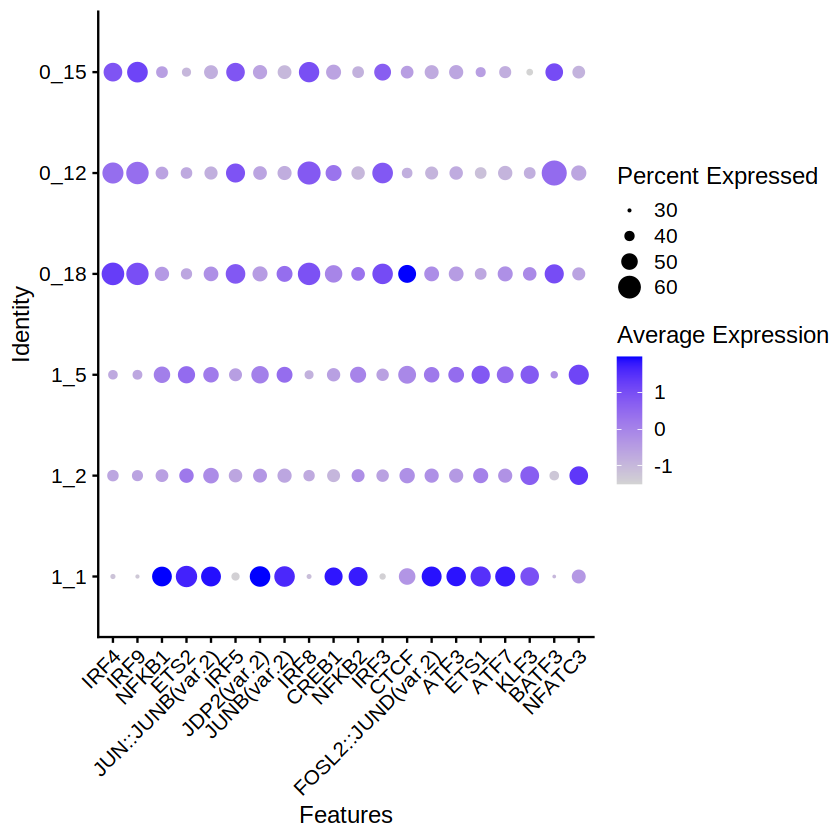

In [14]:
#pdf(file = file.path(outdir, "dotplot.allDonors.clones.top.pdf"), width = 8, height = 8)
dot <- DotPlot(se, features = head(names(sig.motifs.ordered),20), group.by="name", cluster.idents=T) + RotatedAxis()
dot

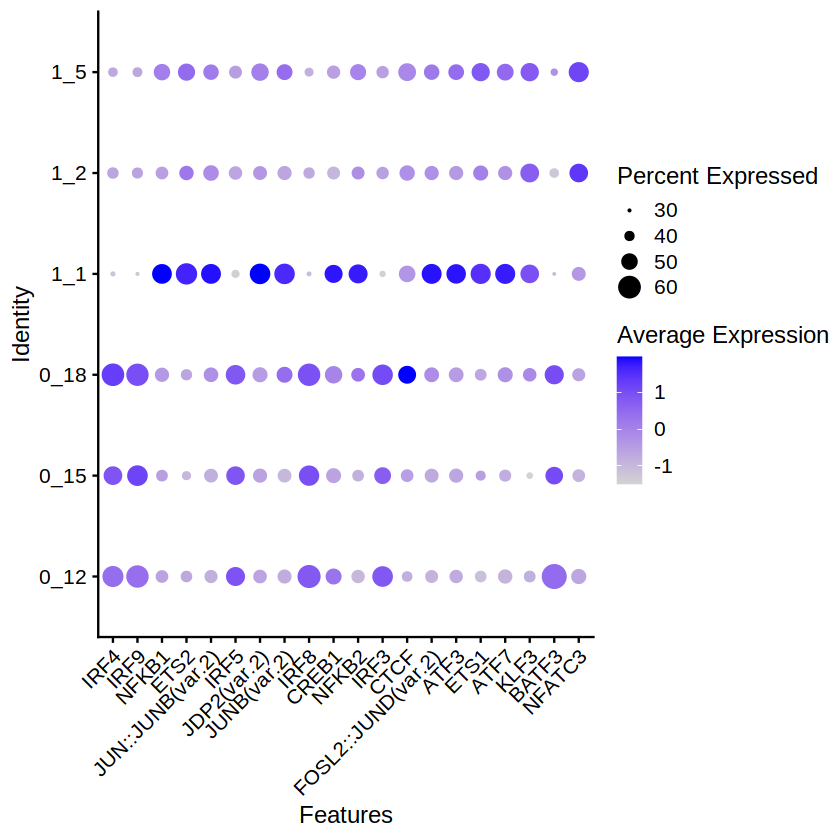

In [15]:
#pdf(file = file.path(outdir, "dotplot.allDonors.clones.top.pdf"), width = 8, height = 8)
dot <- DotPlot(se, features = head(names(sig.motifs.ordered),20), group.by="name", cluster.idents=F) + RotatedAxis()
dot
ggsave(file = file.path(outdir, "dotplot.allDonors.clones.topPval.pdf"), width = 16, height = 16)


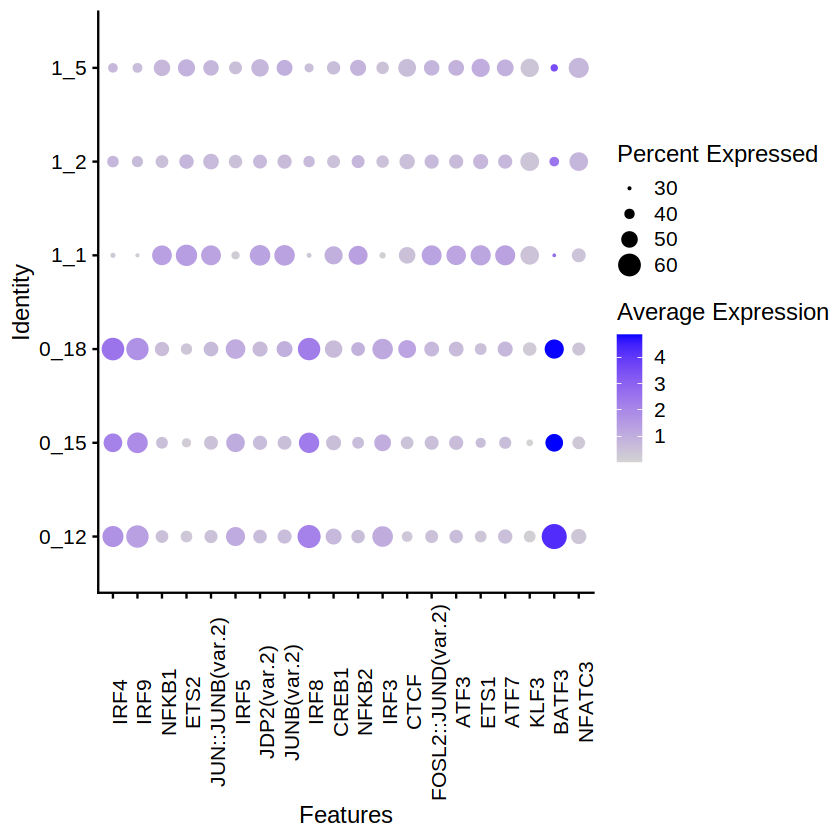

In [16]:
# very add-hoc solution
# ideas from mnel's post in https://stackoverflow.com/questions/13407236/remove-a-layer-from-a-ggplot2-chart

library(ggplot2)
#varFeat <- c("LYZ", "CCL5", "IL32", "PTPRCAP", "FCGR3A", "PF4")
g <- DotPlot(object = se, features = head(names(sig.motifs.ordered),20), assay="chromvarnames")

g$layers[[1]] <- NULL # remove original geom_point layer where the color scale is hard-coded to use scaled average expression
g <- g + 
    geom_point(mapping = aes_string(size = 'pct.exp', color = 'avg.exp')) +
    guides(color = guide_colorbar(title = 'Average Expression')) + 
    theme(axis.text.x = element_text(angle=90))

plot(g)

ggsave(file = file.path(outdir, "dotplot.allDonors.clones.topPval.noZ.pdf"), width = 16, height = 16)


In [17]:
se.avg.order <- data.frame(se.avg.order)
se.avg.order[,"avg_pval_adj_-log10"] = sig.motifs.ordered
se.avg.order

,X0_12,X0_15,X0_18,X1_1,X1_2,X1_5,avg_pval_adj_-log10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IRF4,1.73679549,2.15394528,2.5146371,0.2894727,0.7888015,0.7350676,9.202241
IRF9,1.36430017,1.89013743,1.7727650,0.1782762,0.6598840,0.6081867,8.742983
NFKB1,0.52381615,0.55025319,0.5896595,1.3571117,0.5449076,0.7496702,7.515062
ETS2,0.34639229,0.22061832,0.3684601,1.4478974,0.7708508,0.8872859,7.257906
JUN::JUNB(var.2),0.48503501,0.48770623,0.6569759,1.2729100,0.6780557,0.7716845,7.010475
IRF5,1.07154292,1.05722269,1.0397641,0.2047589,0.5043010,0.5541747,6.933650
JDP2(var.2),0.60540442,0.60649231,0.6458270,1.2864309,0.6679181,0.7849277,6.758903
JUNB(var.2),0.60709420,0.54821898,0.9543459,1.2997227,0.6443721,0.9572252,6.657851
IRF8,2.15165327,2.33138004,2.2946150,0.3048808,0.6687482,0.5560390,6.648229


In [18]:
write.csv(se.avg.order, 
          file=file.path(outdir, "clone_motif_activity_rankByPval.csv"), quote=F)
se.avg.order

,X0_12,X0_15,X0_18,X1_1,X1_2,X1_5,avg_pval_adj_-log10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IRF4,1.73679549,2.15394528,2.5146371,0.2894727,0.7888015,0.7350676,9.202241
IRF9,1.36430017,1.89013743,1.7727650,0.1782762,0.6598840,0.6081867,8.742983
NFKB1,0.52381615,0.55025319,0.5896595,1.3571117,0.5449076,0.7496702,7.515062
ETS2,0.34639229,0.22061832,0.3684601,1.4478974,0.7708508,0.8872859,7.257906
JUN::JUNB(var.2),0.48503501,0.48770623,0.6569759,1.2729100,0.6780557,0.7716845,7.010475
IRF5,1.07154292,1.05722269,1.0397641,0.2047589,0.5043010,0.5541747,6.933650
JDP2(var.2),0.60540442,0.60649231,0.6458270,1.2864309,0.6679181,0.7849277,6.758903
JUNB(var.2),0.60709420,0.54821898,0.9543459,1.2997227,0.6443721,0.9572252,6.657851
IRF8,2.15165327,2.33138004,2.2946150,0.3048808,0.6687482,0.5560390,6.648229


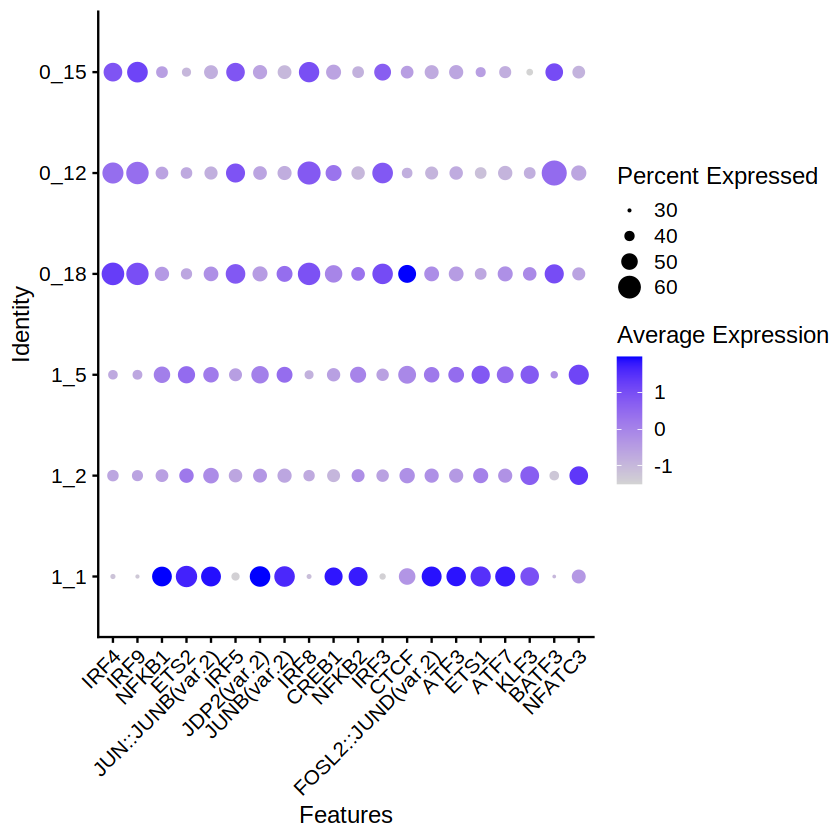

In [19]:
#pdf(file = file.path(outdir, "dotplot.allDonors.clones.top.pdf"), width = 8, height = 8)
dot <- DotPlot(se, features = head(names(sig.motifs.ordered),20), group.by="name", cluster.idents=T) + RotatedAxis()
dot

In [20]:
dim(se.avg.order)

[1] 528   7

In [21]:
se.avg.order[, "avg_pval_adj"] <- sig.motifs.ordered
se.avg.order

,X0_12,X0_15,X0_18,X1_1,X1_2,X1_5,avg_pval_adj_-log10,avg_pval_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IRF4,1.73679549,2.15394528,2.5146371,0.2894727,0.7888015,0.7350676,9.202241,9.202241
IRF9,1.36430017,1.89013743,1.7727650,0.1782762,0.6598840,0.6081867,8.742983,8.742983
NFKB1,0.52381615,0.55025319,0.5896595,1.3571117,0.5449076,0.7496702,7.515062,7.515062
ETS2,0.34639229,0.22061832,0.3684601,1.4478974,0.7708508,0.8872859,7.257906,7.257906
JUN::JUNB(var.2),0.48503501,0.48770623,0.6569759,1.2729100,0.6780557,0.7716845,7.010475,7.010475
IRF5,1.07154292,1.05722269,1.0397641,0.2047589,0.5043010,0.5541747,6.933650,6.933650
JDP2(var.2),0.60540442,0.60649231,0.6458270,1.2864309,0.6679181,0.7849277,6.758903,6.758903
JUNB(var.2),0.60709420,0.54821898,0.9543459,1.2997227,0.6443721,0.9572252,6.657851,6.657851
IRF8,2.15165327,2.33138004,2.2946150,0.3048808,0.6687482,0.5560390,6.648229,6.648229


In [22]:
se.avg.order

,X0_12,X0_15,X0_18,X1_1,X1_2,X1_5,avg_pval_adj_-log10,avg_pval_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IRF4,1.73679549,2.15394528,2.5146371,0.2894727,0.7888015,0.7350676,9.202241,9.202241
IRF9,1.36430017,1.89013743,1.7727650,0.1782762,0.6598840,0.6081867,8.742983,8.742983
NFKB1,0.52381615,0.55025319,0.5896595,1.3571117,0.5449076,0.7496702,7.515062,7.515062
ETS2,0.34639229,0.22061832,0.3684601,1.4478974,0.7708508,0.8872859,7.257906,7.257906
JUN::JUNB(var.2),0.48503501,0.48770623,0.6569759,1.2729100,0.6780557,0.7716845,7.010475,7.010475
IRF5,1.07154292,1.05722269,1.0397641,0.2047589,0.5043010,0.5541747,6.933650,6.933650
JDP2(var.2),0.60540442,0.60649231,0.6458270,1.2864309,0.6679181,0.7849277,6.758903,6.758903
JUNB(var.2),0.60709420,0.54821898,0.9543459,1.2997227,0.6443721,0.9572252,6.657851,6.657851
IRF8,2.15165327,2.33138004,2.2946150,0.3048808,0.6687482,0.5560390,6.648229,6.648229
